# Titanic

In [30]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Ⅰ 数据采集及存储

In [31]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [32]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Ⅱ 数据预处理
* 数据清洗
数据集成
数据变换
数据规约
* 数据缺失
重复
不同计量单位
噪声

### step1 数据清理——处理缺失数据

In [33]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [35]:
# 查看embarked的取值分布
train_data['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [36]:
# 缺失embarked的数据较少（只有两条），用众数填充
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

<AxesSubplot:>

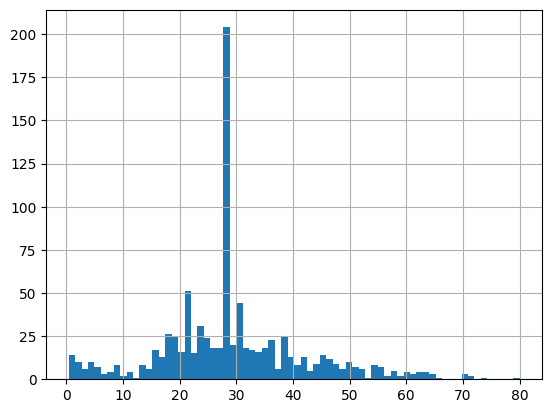

In [40]:
# 查看年龄分布
train_data['Age'].hist(bins=70)
# 选择用中位数填充年龄
# TODO:年龄缺失较多，用KNN/EM/热卡填充预测年龄
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)

In [ ]:
# cabin数据缺失太多，先暂时不填充，待特征工程时再决定如何处理

### 数据清理——噪声处理
* 经检验，数据非常整齐，没有明显噪声

In [144]:
# 观察各特征值有无异常值
a = train_data['PassengerId'].nunique() == train_data.shape[0]
print(f'passengerId各不相同：{a}\n')
b = train_data['Survived'].value_counts()
print(f'Survived 可能的取值：\n{b}\n')
c = train_data['Pclass'].value_counts()
print(f'Pclass 可能的取值：\n{c}\n')
d = train_data["Name"].nunique() == train_data.shape[0]
print(f'Name各不相同：{d}\n')
e = train_data["Sex"].value_counts()
print(f'Sex 可能的取值：\n{e}\n')
f = train_data["Age"].min()
g = train_data["Age"].max()
print(f'Age 可能的取值范围：{f}~{g}\n')
h = train_data["SibSp"].value_counts()
print(f'SibSp 可能的取值：\n{h}\n')
i = train_data["Parch"].value_counts()
print(f'Parch 可能的取值：\n{i}\n')
j = train_data["Ticket"].value_counts()
print(f'Ticket 可能的取值：\n{j}\n')
k = train_data["Fare"].min()
l = train_data["Fare"].max()
print(f'Fare 可能的取值范围：{k}~{l}\n')
m = train_data["Cabin"].value_counts()
print(f'Cabin 可能的取值：\n{m}\n')
n = train_data["Embarked"].value_counts()
print(f'Embarked 可能的取值：\n{n}\n')

# 未发现数据中含有异常值：
# 年龄票价等连续值均大于0且取值符合常理
# 离散值类型一致，不存在数字和字符串混合的情况；id等唯一值各不相同


passengerId各不相同：True

Survived 可能的取值：
0    549
1    342
Name: Survived, dtype: int64

Pclass 可能的取值：
3    491
1    216
2    184
Name: Pclass, dtype: int64

Name各不相同：True

Sex 可能的取值：
male      577
female    314
Name: Sex, dtype: int64

Age 可能的取值范围：0.42~80.0

SibSp 可能的取值：
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Parch 可能的取值：
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Ticket 可能的取值：
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Fare 可能的取值范围：0.0~512.3292

Cabin 可能的取值：
N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

Embarked 可能的取值：
S    646
C    168
Q     77
Name: Embarked, dtype: int64



### step2 数据集成
* 只有一个数据源，无需集成

### step3 数据变换
* 规范化、离散化

In [59]:
# 决策树、随机森林对数据的原始尺度不敏感，可能不需要归一化、离散化
# SVM、KNN、xgboost等模型对数据的尺度敏感，需要归一化、离散化
"""
train_norm = train_data.copy()
test_norm = test_data.copy()
print(train_norm["Age"])
"""


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64


### step4 数据规约

## Ⅲ 特征工程

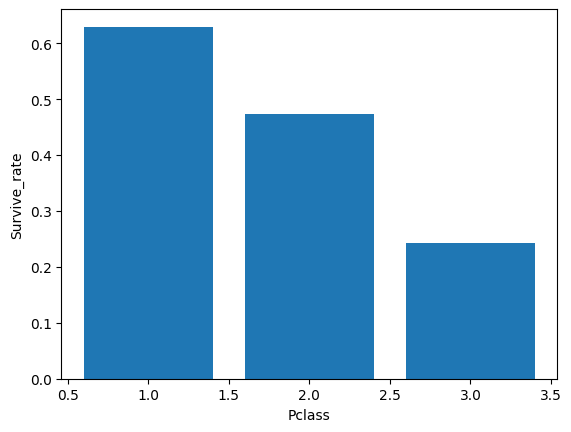

In [66]:
pclass_1 = train_data[train_data.Pclass == 1]
pclass_2 = train_data[train_data.Pclass == 2]
pclass_3 = train_data[train_data.Pclass == 3]
sum_1 = pclass_1.shape[0]
sum_2 = pclass_2.shape[0]
sum_3 = pclass_3.shape[0]
survived_1 = pclass_1[pclass_1.Survived == 1].shape[0]
survived_2 = pclass_2[pclass_2.Survived == 1].shape[0]
survived_3 = pclass_3[pclass_3.Survived == 1].shape[0]
survived_rate_1 = survived_1 / sum_1
survived_rate_2 = survived_2 / sum_2
survived_rate_3 = survived_3 / sum_3
plt.bar([1,2,3],[survived_rate_1,survived_rate_2,survived_rate_3])
plt.xlabel('Pclass')
plt.ylabel('Survive_rate')
plt.show()
# 观察的结果是：Pclass越高，存活率越高

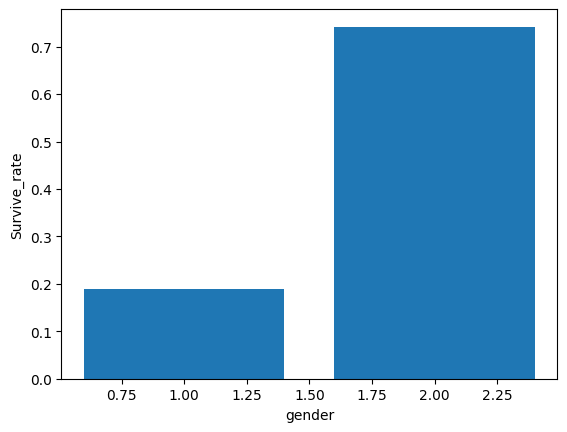

In [67]:
male = train_data[train_data.Sex == 'male']
female = train_data[train_data.Sex == 'female']
sum1 = male.shape[0]
sum2 = female.shape[0]
survived_m = male[male.Survived == 1].shape[0]
survived_f = female[female.Survived == 1].shape[0]
survived_rate_m = survived_m / sum1
survived_rate_f = survived_f / sum2
plt.bar([1,2],[survived_rate_m,survived_rate_f])
plt.xlabel('gender')
plt.ylabel('Survive_rate')
plt.show()
# 观察的结果是：女性存活率更高

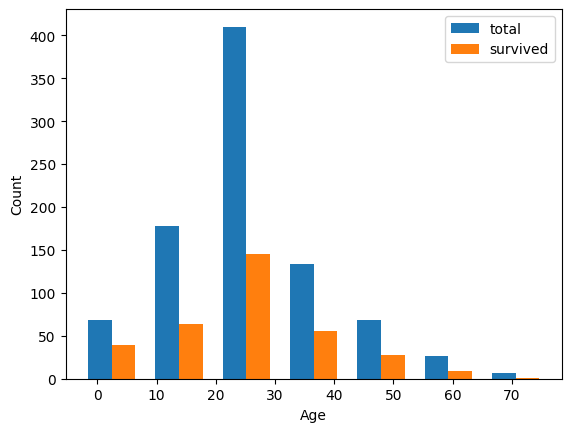

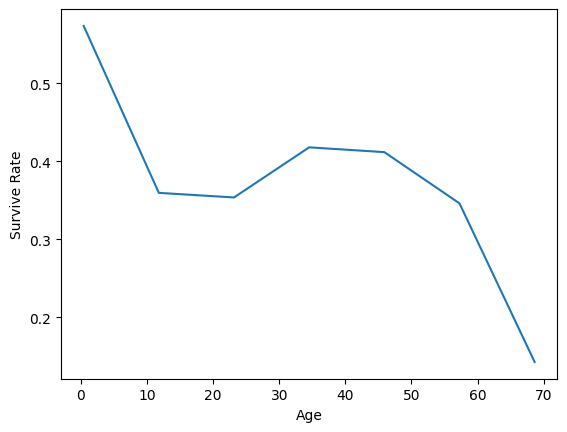

"survived_list = train_data.Survived.tolist()\nage_list = train_data.Age.tolist()\nplt.scatter(age_list, survived_list)\nplt.xlabel('Age')\nplt.ylabel('Survive_ornot')\nplt.show()\n# 观察的结果是：年龄越小，存活人数越多"

In [128]:
age = train_data["Age"].values
bin_width = 10
num_bins = int((age.max() - age.min()) / bin_width)
train_data['age_cul'] = pd.cut(age, num_bins)
survive = train_data[train_data["Survived"] == 1].groupby('age_cul').size().values
hist, bins = np.histogram(age, bins=num_bins)
survive_rate = survive / hist
survive_rate = np.nan_to_num(survive_rate)

width = 0.35 * (bins[1] - bins[0])
plt.bar(bins[:-1], hist, width=width, label='total')
plt.bar(bins[:-1] + width, survive, width=width, label='survived')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.plot(bins[:-1], survive_rate)
plt.xlabel('Age')
plt.ylabel('Survive Rate')
plt.show()

'''survived_list = train_data.Survived.tolist()
age_list = train_data.Age.tolist()
plt.scatter(age_list, survived_list)
plt.xlabel('Age')
plt.ylabel('Survive_ornot')
plt.show()
# 观察的结果是：年龄越小，存活人数越多'''

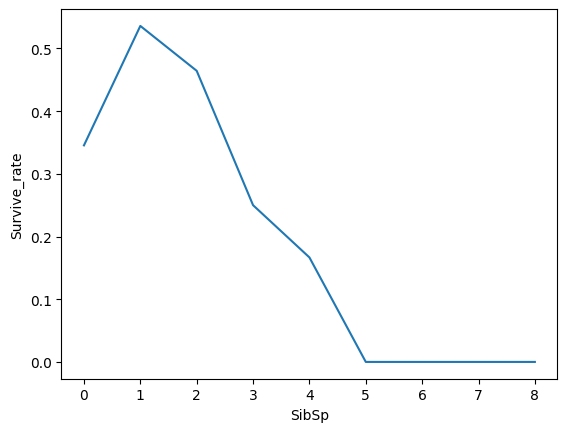

In [72]:
sib1 = train_data[train_data.SibSp == 0]
sib2 = train_data[train_data.SibSp == 1]
sib3 = train_data[train_data.SibSp == 2]
sib4 = train_data[train_data.SibSp == 3]
sib5 = train_data[train_data.SibSp == 4]
sib6 = train_data[train_data.SibSp == 5]
sib7 = train_data[train_data.SibSp == 8]
survived_rate_1 = sib1[sib1.Survived == 1].shape[0] / sib1.shape[0]
survived_rate_2 = sib2[sib2.Survived == 1].shape[0] / sib2.shape[0]
survived_rate_3 = sib3[sib3.Survived == 1].shape[0] / sib3.shape[0]
survived_rate_4 = sib4[sib4.Survived == 1].shape[0] / sib4.shape[0]
survived_rate_5 = sib5[sib5.Survived == 1].shape[0] / sib5.shape[0]
survived_rate_6 = sib6[sib6.Survived == 1].shape[0] / sib6.shape[0]
survived_rate_7 = sib7[sib7.Survived == 1].shape[0] / sib7.shape[0]
plt.plot([0,1,2,3,4,5,8],[survived_rate_1,survived_rate_2,survived_rate_3,survived_rate_4,survived_rate_5,survived_rate_6,survived_rate_7])
plt.xlabel('SibSp')
plt.ylabel('Survive_rate')
plt.show()

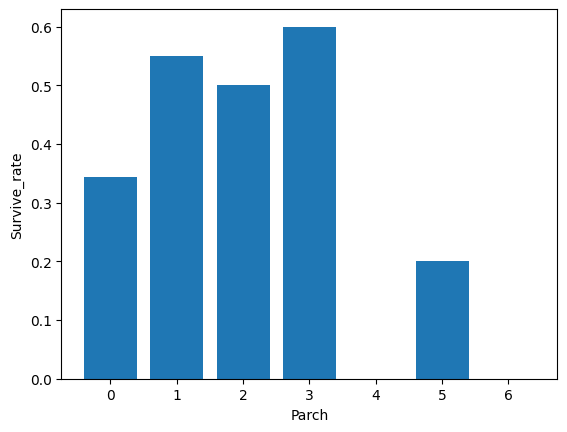

In [69]:
survive_parch1 = train_data[train_data.Parch == 0][train_data[train_data.Parch == 0].Survived == 1].shape[0] / train_data[train_data.Parch == 0].shape[0]
survive_parch2 = train_data[train_data.Parch == 1][train_data[train_data.Parch == 1].Survived == 1].shape[0] / train_data[train_data.Parch == 1].shape[0]
survive_parch3 = train_data[train_data.Parch == 2][train_data[train_data.Parch == 2].Survived == 1].shape[0] / train_data[train_data.Parch == 2].shape[0]
survive_parch4 = train_data[train_data.Parch == 3][train_data[train_data.Parch == 3].Survived == 1].shape[0] / train_data[train_data.Parch == 3].shape[0]
survive_parch5 = train_data[train_data.Parch == 4][train_data[train_data.Parch == 4].Survived == 1].shape[0] / train_data[train_data.Parch == 4].shape[0]
survive_parch6 = train_data[train_data.Parch == 5][train_data[train_data.Parch == 5].Survived == 1].shape[0] / train_data[train_data.Parch == 5].shape[0]
survive_parch7 = train_data[train_data.Parch == 6][train_data[train_data.Parch == 6].Survived == 1].shape[0] / train_data[train_data.Parch == 6].shape[0]
plt.bar([0,1,2,3,4,5,6],[survive_parch1,survive_parch2,survive_parch3,survive_parch4,survive_parch5,survive_parch6,survive_parch7])
plt.xlabel('Parch')
plt.ylabel('Survive_rate')
plt.show()

C:\Users\86135\AppData\Local\Temp\ipykernel_4316\3907820747.py:8: RuntimeWarning: invalid value encountered in true_divide
  survive_rate = survive / hist


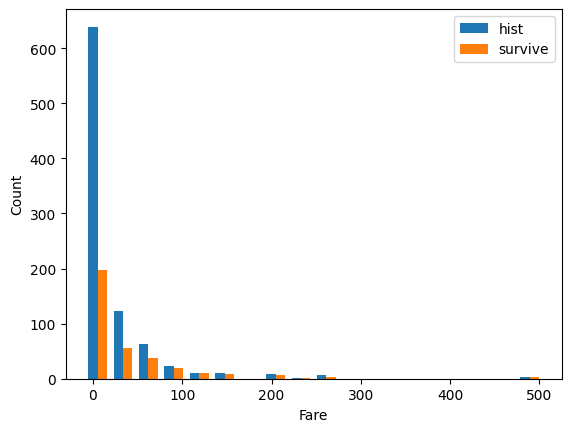

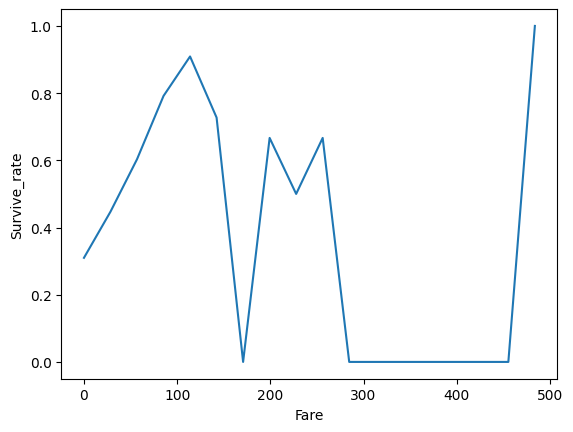

In [117]:
fare = train_data["Fare"].values
bin_width = 30
num_bins = int((fare.max() - fare.min()) / bin_width) + 1
train_data['price_cul'] = pd.cut(fare, bins=num_bins)
survive = train_data[train_data["Survived"] == 1].groupby('price_cul').size()
survive = survive.values
hist, bins = np.histogram(fare, bins=num_bins)
survive_rate = survive / hist
survive_rate = np.nan_to_num(survive_rate)

width = 0.35*bin_width
plt.bar(bins[:-1], hist, width=width, label='hist')
plt.bar(bins[:-1] + width, survive, width=width, label='survive')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.legend()
plt.show()


plt.plot(bins[:-1], survive_rate)
plt.xlabel('Fare')
plt.ylabel('Survive_rate')
plt.show()

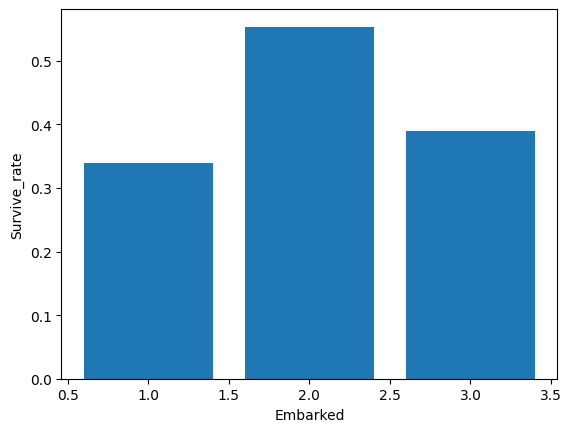

In [129]:
embrak1 = train_data[train_data.Embarked == 'S']
embrak2 = train_data[train_data.Embarked == 'C']
embrak3 = train_data[train_data.Embarked == 'Q']
survive_rate_1 = embrak1[embrak1.Survived == 1].shape[0] / embrak1.shape[0]
survive_rate_2 = embrak2[embrak2.Survived == 1].shape[0] / embrak2.shape[0]
survive_rate_3 = embrak3[embrak3.Survived == 1].shape[0] / embrak3.shape[0]
plt.bar([1,2,3],[survive_rate_1,survive_rate_2,survive_rate_3])
plt.xlabel('Embarked')
plt.ylabel('Survive_rate')
plt.show()


In [41]:
# 查看cabin类型
train_data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [131]:
# 发现cabin完全相同的数据很少，因此简化cabin为其首字母
train_data['Cabin'] = train_data['Cabin'].str[0]
train_data['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

0.4666666666666667 0.7446808510638298 0.5932203389830508 0.7575757575757576 0.75 0.6153846153846154 0.5 0.0


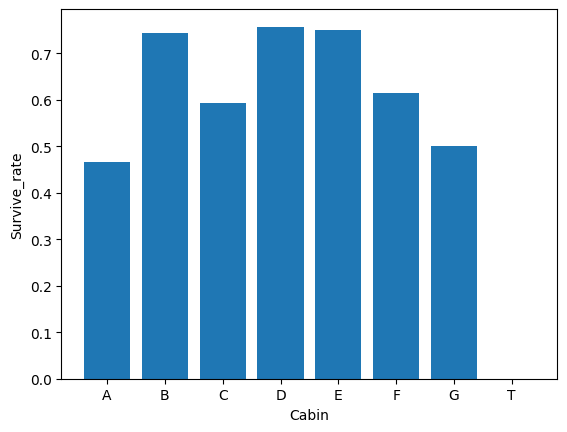

In [140]:
# 查看cabin与survived的关系大不大
A = train_data[train_data.Cabin == 'A']
B = train_data[train_data.Cabin == 'B']
C = train_data[train_data.Cabin == 'C']
D = train_data[train_data.Cabin == 'D']
E = train_data[train_data.Cabin == 'E']
F = train_data[train_data.Cabin == 'F']
G = train_data[train_data.Cabin == 'G']
T = train_data[train_data.Cabin == 'T']
survived_rate_A = A[A.Survived == 1].shape[0] / A.shape[0]
survived_rate_B = B[B.Survived == 1].shape[0] / B.shape[0]
survived_rate_C = C[C.Survived == 1].shape[0] / C.shape[0]
survived_rate_D = D[D.Survived == 1].shape[0] / D.shape[0]
survived_rate_E = E[E.Survived == 1].shape[0] / E.shape[0]
survived_rate_F = F[F.Survived == 1].shape[0] / F.shape[0]
survived_rate_G = G[G.Survived == 1].shape[0] / G.shape[0]
survived_rate_T = T[T.Survived == 1].shape[0] / T.shape[0]
#print(survived_rate_A,survived_rate_B,survived_rate_C,survived_rate_D,survived_rate_E,survived_rate_F,survived_rate_G,survived_rate_T)
plt.bar(['A','B','C','D','E','F','G','T'],[survived_rate_A,survived_rate_B,survived_rate_C,survived_rate_D,survived_rate_E,survived_rate_F,survived_rate_G,survived_rate_T])
plt.xlabel('Cabin')
plt.ylabel('Survive_rate')
plt.show()

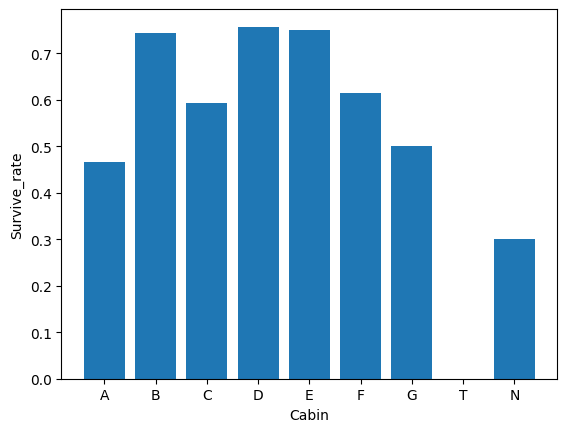

In [141]:
# 发现有cabin标记的数据存活率更高，因此将没有cabin标记的数据标记为‘N’
train_data['Cabin'].fillna('N', inplace=True)

N = train_data[train_data.Cabin == 'N']
survived_rate_N = N[N.Survived == 1].shape[0] / N.shape[0]
plt.bar(['A','B','C','D','E','F','G','T','N'],[survived_rate_A,survived_rate_B,survived_rate_C,survived_rate_D,survived_rate_E,survived_rate_F,survived_rate_G,survived_rate_T,survived_rate_N])
plt.xlabel('Cabin')
plt.ylabel('Survive_rate')
plt.show()
# 观察到N与其他cabin的差距和cabin间的差距没有很大，因此当前的划分方式比将cabin分为有无两类更合理

### 独热编码
* 将离散且标签间没有明显顺序关系的特征转化为独热编码
  * 此处仅有embark符合这个条件

In [145]:
# embark拆分成三列
train_data = pd.get_dummies(train_data, columns=['Embarked'])
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,price_cul,age_cul,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,N,"(-0.512, 28.463]","(11.789, 23.157]",0,0,1


## Ⅳ 模型构建及训练

In [12]:
y = train_data["Survived"]

features = ["Pclass","Sex","SibSp","Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X,y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('data/my_submission.csv', index=False)